In [2]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers
from sklearn.decomposition import PCA
from sklearn.cluster import *

In [3]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location, 'labelled')

reading outlooks
reading pph
reading storm reports


# Preprocessing

In [7]:
category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}


season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Great Plains': 1,
    'Midwest': 2,
    'Northeast': 3,
    'South': 4
}

tor_dict = {
    'NONE': -1,
    'EFU': 0,
    '(E)F0': 1,
    '(E)F1': 2,
    '(E)F2': 3,
    '(E)F3': 4,
    '(E)F4': 5,
    '(E)F5': 6
}

cats = ['MAX_CAT', 'SEASON', 'TOR_F']
dicts = [category_dict, season_dict, tor_dict]

In [8]:
# remove unneeded variables and x, y dimensions
data = pph.drop(['lat', 'lon', 'p_perfect_wind', 'p_perfect_sig_wind', 'p_perfect_hail', 'p_perfect_sig_hail', 'p_perfect_tor', 'p_perfect_sig_tor', 'RAMP_CAT', 'p_perfect_total', 'p_perfect_max', 'PPH_CAT', 'PPH_NUM', 'PPH_D_CAT', 'WINDSP_CAT', 'HAILSZ_CAT', 'REGION', 'REGION_M'])


# make data numerical
def convert_strings_to_ints(data, conversion_dict):
    return np.vectorize(conversion_dict.get)(data)

for cat, dic in zip(cats, dicts):

    data[cat] = xr.apply_ufunc(
        convert_strings_to_ints,  # function to apply
        data[cat],      # input data
        kwargs={'conversion_dict': dic},  # additional arguments
        vectorize=True            # vectorize the function
    )

In [9]:
# consolidate dates 
earliest_date = max(min(outlooks['DATE']), min(pph['time']), min(reports['DATE'])) #TODO first two days of outlook dataset don't have day 3 forecast. but probably ok since not mdt
latest_date = min(max(outlooks['DATE']), max(pph['time']), max(reports['DATE']))

In [10]:
earliest_date = '200203300000'
all_pph_dates = data['time']
pph_dates = all_pph_dates[all_pph_dates <= latest_date]
pph_dates = pph_dates[pph_dates >= earliest_date]
new_data = data.sel(time = pph_dates)

In [11]:
# pick subset
new_data = new_data.where(new_data['MAX_CAT'] >= 4, drop = True)

In [12]:
def standardize_dataset(dataset):
    standardized_data = {}
    means = []
    stds = []

    for var in dataset.data_vars:
        data_array = dataset[var]
        mean = data_array.values.mean()
        means.append(mean)
        std = data_array.values.std()
        stds.append(std)
        standardized_data[var] = (data_array - mean) / std
    return xr.Dataset(standardized_data), means, stds

def unstandardize_dataset(data, means, stds):
    var_names = list(new_data.keys())
    for i, var in zip(range(len(var_names)), var_names):
        data[var] = data[var] * stds[i] + means[i]
    return data

new_data, means, stds = standardize_dataset(new_data)

# PCA

In [13]:
# do pca
data_matrix = new_data.to_array(dim = 'time').data.T
pca = PCA()

pca.fit(data_matrix)

PCA()

PC 0
MAX_CAT: 0.11484063486435302
RAMP_UP: 0.011597011675773095
RAMP_DOWN: 0.04746419732605135
SEASON: 0.010748307758614527
REPORT_NUM: 0.39092990049183607
TOR_NUM: 0.22896902555512494
WIND_NUM: 0.3523076988461981
HAIL_NUM: 0.2359189239111611
TOR_F: 0.16109613112241045
WINDSP_NUM: 0.22666796617413346
HAILSZ_NUM: 0.16026109479712153
NEIGH_NUM: 0.35687149397947143
RMSE_NUM: 0.338433105664499
BS_NUM: 0.36338243031657014
LAT_NUM: 0.05253515392779654
LON_NUM: 0.09091150680770894
PPH_D_NUM: 0.33361278820683915
PC 1
MAX_CAT: -0.3300438381460237
RAMP_UP: -0.11953510209269858
RAMP_DOWN: -0.13044279434384637
SEASON: 0.24137137567142386
REPORT_NUM: -0.00782521379123445
TOR_NUM: -0.3523668111035385
WIND_NUM: 0.23756669787786294
HAIL_NUM: -0.2927954417817972
TOR_F: -0.4260109736911264
WINDSP_NUM: -0.09597049275596517
HAILSZ_NUM: -0.3540236798647187
NEIGH_NUM: 0.18053092515400887
RMSE_NUM: 0.25601257252052584
BS_NUM: 0.16877500341913076
LAT_NUM: 0.1094666271771965
LON_NUM: 0.2798545814412727
PPH_D_N

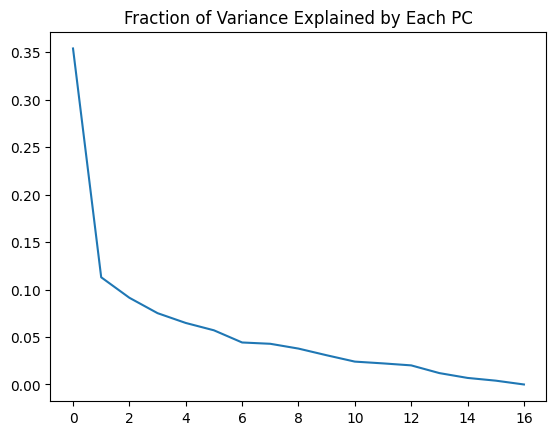

In [14]:
# Print variance expained and componenets of first PCs
plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_))
plt.title('Fraction of Variance Explained by Each PC')
keys = list(new_data.keys())
for i in range(6):
    print('PC ' + str(i))
    pc = pca.components_[i, :]
    for j in range(len(pc)):
        print(keys[j] + ': ' + str(pc[j]))
    

# Clustering

In [15]:
def plot_clusters(centers, keys, cluster_method = 'METHOD', sizekey = None, sizestring = 'XX', shapekey = None, shapestring = 'XX', colorkey = None, colorstring = 'XX', fill_cmap = 'viridis', edgekey = None, edgestring = 'XX', edge_cmap = 'viridis', save = False, show = True, save_location = 'plots'):
    fig=plt.figure(figsize=(15,6))
    plt.style.use('dark_background')
    ax = plt.axes(projection = cp.crs.LambertConformal())
    ax.add_feature(cp.feature.LAND,facecolor='grey')
    ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
    ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
    ax.add_feature(cp.feature.LAKES, alpha = 0.5)
    ax.add_feature(cp.feature.STATES,linewidth=0.5)

    lats = np.empty(centers.shape[0])
    lons = np.empty(centers.shape[0])
    sizes = np.empty(centers.shape[0]) # pick a scale
    shapes = np.empty(centers.shape[0]) # will do pointier for higher numbers
    colors = np.empty(centers.shape[0]) # pick a scale
    edges = np.empty(centers.shape[0]) # pick a scale

    for i in range(centers.shape[0]):
        center = centers[i, :]
        for j in range(len(center)):
            keyj = keys[j]
            centerj = center[j]
            #print(keyj + ': ' + str(centerj))
            if keyj == 'LAT_NUM':
                lats[i] = centerj
            elif keyj == 'LON_NUM':
                lons[i] = centerj
            elif keyj == sizekey:
                sizes[i] = centerj
            elif keyj == shapekey:
                shapes[i] = centerj
            elif keyj == colorkey:
                colors[i] = centerj
            elif keyj == edgekey:
                edges[i] = centerj

    # PLOTTING    

    # Dynamic binning for shapes
    num_bins = 5  # Number of shapes
    bins = np.linspace(min(shapes), max(shapes), num_bins)  # Corrected binning
    shape_dict = {0: 'o', 1: 'H', 2: 's', 3: 'P', 4: '*'}  # Circle, Square, Diamond, Triangle

    # Bin the shapes variable
    shape_bins = np.digitize(shapes, bins) - 1  # -1 to match dictionary keys

    # Normalize colors and edge colors
    norm_colors = plt.Normalize(vmin=min(colors), vmax=max(colors))
    norm_edge_colors = plt.Normalize(vmin=min(edges), vmax=(max(edges)))

    # Convert to RGBA using colormap
    colors_rgba = plt.cm.get_cmap(fill_cmap)(norm_colors(colors))
    edge_colors_rgba = plt.cm.get_cmap(edge_cmap)(norm_edge_colors(edges))

    # Plot each shape separately based on the binned shapes
    for bin_idx in np.unique(shape_bins):
        ix = shape_bins == bin_idx
        ax.scatter(
            lons[ix], lats[ix], 
            s=sizes[ix], 
            c=colors[ix], 
            edgecolor=edge_colors_rgba[ix],  # Use RGBA colors for edge colors
            linewidth=3,  
            marker=shape_dict[bin_idx], 
            cmap=fill_cmap, 
            transform=cp.crs.PlateCarree(),
            alpha=1
        )

    ax.set_xlim(-2400000, 2300000)
    ax.set_ylim(-1700000, 1800000)

    # Add the first colorbar for internal colors
    cbar1 = plt.colorbar(ax.collections[0], ax=ax)
    cbar1.set_label(colorstring + ' (Fill)')

    # Create a dummy scatter plot for the edge colors colorbar
    scatter_dummy = ax.scatter(
        [], [], c=[], edgecolor=edge_colors_rgba, cmap=edge_cmap, alpha=1
    )

    # Add the second colorbar for edge colors
    cbar2 = plt.colorbar(scatter_dummy, ax=ax)
    cbar2.set_label(edgestring + ' (Edge)')

    # Dynamic size legend with gray points only
    unique_sizes = np.percentile(sizes, [10, 30, 50, 70, 90])
    for size in unique_sizes:
        plt.scatter([], [], s=size, color='gray', label=f'{int(size)} ' + sizestring, edgecolor='gray')

    # Dynamic shape legend with gray shapes only
    for bin_idx, shape in shape_dict.items():
        plt.scatter([], [], marker=shape, color='gray', label=f'{bins[bin_idx]:.3} ' + shapestring, edgecolor='gray')

    # Combine size and shape legends into one and position it further to the right of the colorbars
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.6, 0.5), title="Size & Shape Legend", frameon=False)

    plt.title('Cluster Centers with ' + cluster_method)
    
    if save:
        plt.savefig(save_location + '/clustering/' + cluster_method + '/clusters.png')
    if not show:
        plt.close()
    else:
        plt.show()

In [16]:
# cluster with, k-means, knn, optics, birch, dbscan look here for use cases https://scikit-learn.org/stable/modules/clustering.html
# Will want to come up with way to visualize: put location on map, color code by other value(s)? Then do similar for many clustering methods

save = True

# Define constants for plots
sizekey='REPORT_NUM'
sizestring = 'Total Reports'
colorkey= 'NEIGH_NUM'
colorstring = 'Neighborhood Brier Score'
fill_cmap = 'turbo'
shapekey = 'TOR_F'
shapestring = 'Max Tornado Rating'
edgekey = 'SEASON'
edgestring = 'Season'
edge_cmap = 'gist_earth'



clustering_algorithms = {
    'KMeans': KMeans,
    'OPTICS': OPTICS,
    #'DBSCAN': DBSCAN,
    'AgglomerativeClustering': AgglomerativeClustering,
    'MeanShift': MeanShift,
    'Birch': Birch,
    'SpectralClustering': SpectralClustering
}

#def cluster_full(data_matrix)
for name, cls in clustering_algorithms.items():
    print(name)
    X = data_matrix
    c = cls().fit(X)
    if hasattr(c, 'cluster_centers_'):
        centers = (c.cluster_centers_ * stds + means)
    else:
        labels = cls().fit_predict(X)
        if name == 'DBSCAN' or name == 'OPTICS':
            unique_labels = set(labels) - {-1}
        else: 
            unique_labels = set(labels)
        centers = np.empty((len(unique_labels), X.shape[1]))
        for label, i in zip(unique_labels, range(len(unique_labels))):
            cluster_points = X[labels == label]
            centroid = cluster_points.mean(axis=0)
            centers[i, :] = centroid
        centers = centers * stds + means
    
    result_string = ''

    for i in range(centers.shape[0]):
        result_string += '\nCluster ' + str(i) + ':'
        for j in range(centers.shape[1]):
            result_string += '\n' + str(keys[j]) + ': ' + str(centers[i, j])
    
    if save:
        path = 'plots/clustering/'+name
        if not os.path.exists(path):
            os.makedirs(path)
        with open('plots/clustering/' + name + '/centers.txt', "w") as file:
            file.write(result_string)

    plot_clusters(centers, keys, cluster_method = name, sizekey='REPORT_NUM', sizestring = 'Total Reports', colorkey= 'NEIGH_NUM', colorstring = 'Neighborhood Brier Score', fill_cmap = 'turbo', shapekey = 'TOR_F', shapestring = 'Max Tornado Rating', edgekey = 'SEASON', edgestring = 'Season', edge_cmap = 'gist_earth', save = save, show = False)
        


KMeans


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


OPTICS
AgglomerativeClustering
MeanShift
Birch
SpectralClustering


# Cluster by one or two characteristics, show all characteristics

In [96]:
def cluster_partial(dataset, cluster_vars, clustering_algorithms, save = True, save_loc = None, show = False, sizekey='REPORT_NUM', sizestring = 'Total Reports', colorkey= 'NEIGH_NUM', colorstring = 'Neighborhood Brier Score', fill_cmap = 'turbo', shapekey = 'TOR_F', shapestring = 'Max Tornado Rating', edgekey = 'SEASON', edgestring = 'Season', edge_cmap = 'gist_earth'):
    # clusters data in given variables and returns dictionary (by cluster method) of lists of datasets of points in each cluster
    new_data, means, stds = standardize_dataset(dataset)
    
    ret = {key: [] for key in clustering_algorithms}

    X = new_data[cluster_vars].to_array(dim = 'time').data.T
    for name, cls in clustering_algorithms.items():
        print(name)
        datasets = []
        labels = cls().fit_predict(X)
        for cluster_num in set(labels):
            datasets.append(dataset.sel(time=dataset['time'][labels == cluster_num]))
        ret[name] = datasets
    return(ret)


In [97]:
unstandardized_data = data.sel(time = pph_dates)
unstandardized_data = unstandardized_data.where(unstandardized_data['MAX_CAT'] >= 4, drop = True)

d = cluster_partial(unstandardized_data, ['LAT_NUM', 'LON_NUM'], clustering_algorithms, save = False, show = True)

KMeans
OPTICS


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


AgglomerativeClustering
MeanShift
Birch
SpectralClustering


<xarray.Dataset>
Dimensions:     (time: 47, x: 93, y: 65)
Coordinates:
  * time        (time) object '200204210000' '200204270000' ... '202203300000'
  * x           (x) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 88.0 89.0 90.0 91.0 92.0
  * y           (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 60.0 61.0 62.0 63.0 64.0
Data variables: (12/17)
    MAX_CAT     (time) float64 4.0 4.0 4.0 5.0 4.0 4.0 ... 4.0 4.0 4.0 5.0 4.0
    RAMP_UP     (time) float64 4.0 2.0 2.0 3.0 2.0 2.0 ... 1.0 2.0 2.0 2.0 1.0
    RAMP_DOWN   (time) float64 -2.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SEASON      (time) float64 1.0 1.0 1.0 3.0 1.0 1.0 ... 1.0 2.0 1.0 1.0 1.0
    REPORT_NUM  (time) float64 45.0 135.0 169.0 382.0 ... 302.0 150.0 326.0
    TOR_NUM     (time) float64 2.0 30.0 14.0 97.0 112.0 ... 9.0 24.0 38.0 97.0
    ...          ...
    NEIGH_NUM   (time) float64 0.0007377 0.001568 ... 0.000681 0.001858
    RMSE_NUM    (time) float64 0.008889 0.02033 0.01045 ... 0.009851 0.01535
    BS_NUM      (time) float64 0.002812 0.006065 0.004558 ... 0.004961 0.006987
    LAT_NUM     (time) float64 38.42 37.75 38.42 37.63 ... 36.87 36.2 34.77 35.6
    LON_NUM     (time) float64 -87.75 -88.69 -87.75 ... -86.12 -86.23 -88.82
    PPH_D_NUM   (time) float64 49.05 73.23 54.0 81.48 ... 81.32 79.6 45.85 87.84
Attributes:
    title:         Practically Perfect Wind Hindcasts
    grid:          80-km NCEP 211
    sigma:         1.5
    author:        Dr. Victor Gensini
    author_email:  vgensini@niu.edu
    citation:      https://doi.org/10.1175/BAMS-D-19-0321.1

In [95]:
set(unstandardized_data['MAX_CAT'].values)

{4.0, 5.0}